# <center>Домашнее задание
## Сверточные сети
Необязательное домашнее задание
1. Реализовать сверточный автокодировщик
2. Сделать оптимизацию изображения под активацию сверточных нейронов классификатора
3. Сделать оптимизацию изображения под активацию сверточных нейронов автокодировщика

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform, path='./../MNIST_data')

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Создаем необходимые классы

In [9]:
class Encoder(nn.Module):
    def __init__(self, channels=16, latent_size=10):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(28*28*channels, latent_size)
        self.channels = channels
    
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 28*28*self.channels)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, channels=16, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28*channels)
        self.convtrans1 = nn.ConvTranspose2d(in_channels=channels, out_channels=1, kernel_size=5, stride=1, padding=2)
        self.channels = channels
    
    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, self.channels, 28, 28)
        x = self.convtrans1(x)
        x = torch.tanh(x)
        return x

In [10]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size).to(device)
        self.D = Decoder(latent_size).to(device)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [11]:
def train(epoch, models, loader, log=None, noise=False, mode='crop', elementwise=False, verbose_num=1):
    train_size = len(loader.sampler)
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        if noise:
            noised = add_noise(data, mode, elementwise)
        else:
            noised = data
        
        for model in models.values():
            model = model.to(device)
            model.optim.zero_grad()
            output = model(noised)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
    if log is not None:
        for k in models:
            log[k].append(models[k]._loss)   
            
    if epoch == 1 or epoch % verbose_num == 0:
        line = 'Epoch: {} [{}]\n'.format(epoch, train_size)
        losses = '\t' + 'Train set: ' + \
                 ' '.join(['{}: loss: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        report = line + losses
        print(report)

In [12]:
def test(epoch, models, loader, log=None, noise=False, mode='crop', elementwise=False, verbose_num=1):
    test_size = len(loader.sampler)

    test_loss = {mod_label: 0. for mod_label in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            if noise:
                noised = add_noise(data, mode, elementwise)
            else:
                noised = data
            
            output = {mod_label: model(noised) for mod_label, model in models.items()}
            for mod_label, model in models.items():
                test_loss[mod_label] += model.loss(output[mod_label], noised, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    if epoch == 1 or epoch % verbose_num == 0:
        avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
        line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
        
        losses = ' '.join([line(k, test_loss[k]) for k in models])
        report = '\t' + 'Test set: ' + losses   
        print(report)

#### Тренируем автокодировщики с 32-мерным латентным слоем, включая, естественно, энкодер

In [13]:
%%time

models = {'32': Net(32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

for epoch in np.arange(3) + 1:
    for model in models.values():
        model.train()
    train(epoch, models, train_loader, train_log)
    for model in models.values():
        model.eval()
    test(epoch, models, test_loader, test_log)

Epoch: 1 [60000]
	Train set: 32: loss: 0.309772
	Test set: 32: loss: 0.3090
Epoch: 2 [60000]
	Train set: 32: loss: 0.263449
	Test set: 32: loss: 0.2525
Epoch: 3 [60000]
	Train set: 32: loss: 0.210345
	Test set: 32: loss: 0.2051
Wall time: 7min 43s


#### посмотрим на кривые обучения

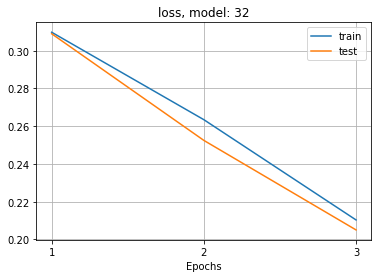

In [14]:
for model in models:
    plt.plot(range(1, len(train_log[model])+1), train_log[model], label="train")
    plt.plot(range(1, len(test_log[model])+1), test_log[model], label="test")
    plt.title(f"loss, model: {model}")
    plt.xlabel("Epochs")
    plt.xticks(range(1, len(train_log[model])+1))
    plt.legend()
    plt.grid()
    plt.show()

### Отрисуем веса фильтров сверток кодера (conv) и декодера (transpose conv)

In [15]:
encoders ={model: models[model].E for model in models}
decoders ={model: models[model].D for model in models}

In [18]:
def plot_coder_filtes(layer, size):
    to_plot = layer.weight.data.cpu().numpy()
    plot_mnist(to_plot, size)

#### сверточное ядро кодера (conv)

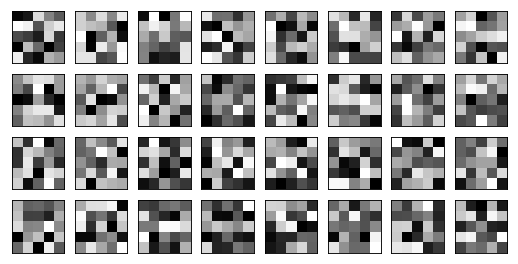

In [19]:
plot_coder_filtes(encoders["32"].conv1, (4, 8))

#### сверточное ядро кодера (transpose conv)

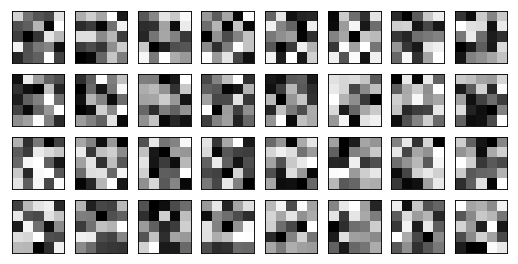

In [20]:
plot_coder_filtes(decoders["32"].convtrans1, (4, 8))